# MNIST Large Untrained Net CNN

Derived from https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial/notebook

In [13]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

print(tf.__version__)

2.8.2


## Load data

In [14]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [15]:
input_shape = (28, 28, 1)

x_train=x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_train=x_train / 255.0
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_test=x_test/255.0

In [16]:
y_train = tf.one_hot(y_train.astype(np.int32), depth=10)
y_test = tf.one_hot(y_test.astype(np.int32), depth=10)

tf.Tensor([0. 0. 0. 0. 0. 1. 0. 0. 0. 0.], shape=(10,), dtype=float32)


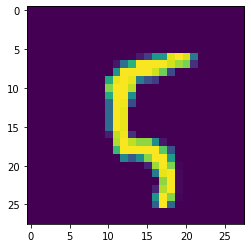

In [17]:
plt.imshow(x_train[100][:,:,0])
print(y_train[100])

## Define model

In [18]:
batch_size = 64
num_classes = 10
epochs = 5

In [19]:
numberOfHiddenLayers = 2    #default = 5, if 0 then useSVM=True
generateLargeNetworkUntrained = True
useSparsity = True
if(useSparsity):
    sparsityProbabilityOfConnection = 0.1 #1-sparsity
addSkipLayers = False
if(numberOfHiddenLayers > 1):
    addSkipLayers = False #True    #optional

if(generateLargeNetworkUntrained):
    generateNetworkUntrained = True
    largeNetworkRatio = 10 #0.2 #1    #10    #100
    generateLargeNetworkExpansion = False
    if(generateLargeNetworkExpansion):
        generateLargeNetworkRatioExponential = False
else:
    generateNetworkUntrained = False
    generateLargeNetworkRatio = False

def kernelInitializerWithSparsity(shape, dtype=None):
    initialisedWeights = tf.random.normal(shape, dtype=dtype) #change to glorot_uniform?
    sparsityMatrixMask = tf.random.uniform(shape, minval=0.0, maxval=1.0, dtype=tf.dtypes.float32)
    sparsityMatrixMask = tf.math.less(sparsityMatrixMask, sparsityProbabilityOfConnection)
    sparsityMatrixMask = tf.cast(sparsityMatrixMask, dtype=tf.dtypes.float32)
    initialisedWeights = tf.multiply(initialisedWeights, sparsityMatrixMask)
    return initialisedWeights
if(useSparsity):
    kernelInitializer = kernelInitializerWithSparsity
else:
    kernelInitializer = 'glorot_uniform'
        

def getLayerRatio(layerIndex):
    layerRatio = 1
    if(generateLargeNetworkUntrained):
        if(generateLargeNetworkExpansion):
            if(generateLargeNetworkRatioExponential):
                layerRatio = largeNetworkRatio**layerIndex
            else:
                layerRatio = largeNetworkRatio * layerIndex
        else:
            layerRatio = largeNetworkRatio
    else:
        layerRatio = 1
    return layerRatio #int(layerRatio)

In [20]:

x = tf.keras.layers.Input(shape=input_shape)
hLast = x
if(numberOfHiddenLayers >= 1):
    layerRatio = getLayerRatio(1)
    h1 = tf.keras.layers.Conv2D(32*layerRatio, (5,5), kernel_initializer=kernelInitializer, padding='same', activation='relu')(x)
    hLast = h1
if(numberOfHiddenLayers >= 2):
    layerRatio = getLayerRatio(2)
    h2 = tf.keras.layers.Conv2D(32*layerRatio, (5,5), kernel_initializer=kernelInitializer, padding='same', activation='relu')(h1)
    h2 = tf.keras.layers.MaxPool2D()(h2)
    h2 = tf.keras.layers.Dropout(0.25)(h2)
    hLast = h2
if(numberOfHiddenLayers >= 3):
    layerRatio = getLayerRatio(3)
    h3 = tf.keras.layers.Conv2D(32*layerRatio, (3,3), kernel_initializer=kernelInitializer, padding='same', activation='relu')(h2)
    hLast = h3
if(numberOfHiddenLayers >= 4):
    layerRatio = getLayerRatio(4)
    h4 = tf.keras.layers.Conv2D(32*layerRatio, (3,3), kernel_initializer=kernelInitializer, padding='same', activation='relu')(h3)
    h4 = tf.keras.layers.MaxPool2D(strides=(2,2))(h4)
    h4 = tf.keras.layers.Flatten()(h4)
    hLast = h4
if(numberOfHiddenLayers >= 5):
    layerRatio = getLayerRatio(5)
    h5 = tf.keras.layers.Dense(128*layerRatio, kernel_initializer=kernelInitializer, activation='relu')(h4)
    h5 = tf.keras.layers.Dropout(0.5)(h5)
    hLast = h5
if(addSkipLayers):
    mList = []
    if(numberOfHiddenLayers >= 1):
        m1 = tf.keras.layers.Flatten()(h1)
        mList.append(m1)
    if(numberOfHiddenLayers >= 2):
        m2 = tf.keras.layers.Flatten()(h2)
        mList.append(m2)
    if(numberOfHiddenLayers >= 3):
        m3 = tf.keras.layers.Flatten()(h3)
        mList.append(m3)
    if(numberOfHiddenLayers >= 4):
        m4 = tf.keras.layers.Flatten()(h4)
        mList.append(m4)
    if(numberOfHiddenLayers >= 5):
        m5 = h5
        mList.append(m5)
    hLast = tf.keras.layers.concatenate(mList)
hLast = tf.keras.layers.Flatten()(hLast)    #flatten hLast if necessary (ie numberOfHiddenLayers <4)
if(generateNetworkUntrained):
    hLast = tf.keras.layers.Lambda(lambda x: tf.keras.backend.stop_gradient(x))(hLast)
y = tf.keras.layers.Dense(num_classes, activation='softmax')(hLast)
model = tf.keras.Model(x, y)

print(model.summary())

model.compile(optimizer=tf.keras.optimizers.RMSprop(epsilon=1e-08), loss='categorical_crossentropy', metrics=['acc'])


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 320)       8320      
                                                                 
 conv2d_3 (Conv2D)           (None, 28, 28, 320)       2560320   
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 320)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 320)       0         
                                                                 
 flatten_1 (Flatten)         (None, 62720)             0         
                                                           

In [21]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>0.995):
            print("\nReached 99.5% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()

## Train model

In [22]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    validation_split=0.1,
                    callbacks=[callbacks])

Epoch 1/5


844/844 [==============================] - 3785s 4s/step - loss: 32.2363 - acc: 0.8625 - val_loss: 6.5978 - val_acc: 0.9703
Epoch 2/5
844/844 [==============================] - 3875s 5s/step - loss: 14.8020 - acc: 0.9312 - val_loss: 6.3840 - val_acc: 0.9715
Epoch 3/5
844/844 [==============================] - 3737s 4s/step - loss: 11.6696 - acc: 0.9475 - val_loss: 9.5686 - val_acc: 0.9590
Epoch 4/5
844/844 [==============================] - 3747s 4s/step - loss: 9.6248 - acc: 0.9552 - val_loss: 10.1087 - val_acc: 0.9542
Epoch 5/5
844/844 [==============================] - 3741s 4s/step - loss: 9.0170 - acc: 0.9605 - val_loss: 9.4287 - val_acc: 0.9650


## Evaluate model

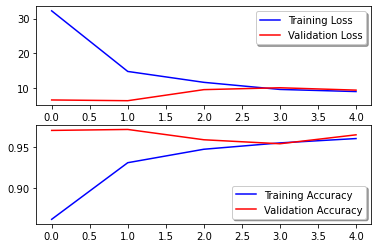

In [23]:
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training Loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation Loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training Accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation Accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [24]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 632s 2s/step - loss: 10.7822 - acc: 0.9558
